* [Задачи](#task)
* [Доп. функции](#extra_funcs)
* [Функции для парсера](#parcer_funcs)
    - [Функция для поиска вакансий по заданным параметрам](#func_find_ids)
    - [Функция обработки вакансии для добавления в таблицу](#func_fill_row)
    - [Функция создания и заполнения таблицы вакансий](#func_ceate_df)
    - [Форматная предобработка данных в таблице](#func_table_processing)
* [Парсим данные или читаем данные из файла](#main)
    - [Вывод](#main_conclusion)
* [Обработка данных](#data_processing)
    - [Удаление явных дубликатов](#data_drop_dublicates)
    - [Обработка валютных вакансий](#data_processing_usd)
    - [Добавление новых столбцов](#data_add_new_column)
* [Анализ зарплат](#data_analysis_salary)
    - [Анализ зарплат "от/до"](#data_salary_from_to)
    - [Зависимость зарплаты "от/до" от опыта](#data_salary_to_lvl)
    - [Анализ среднего зарплаты](#data_salary_mean)
    - [Вывод](#data_salary_conclusion)
    - [Зависимость зарплаты от города](#data_salary_city)
    - [Вывод](#data_salary_city_conclusion)
* [Анализ навыков и описания вакансий](#data_skills_description)
    - [Анализ ключевых навыков](#data_skills)
    - [Анализ описания вакансий](#data_description)
    - [Сравнение ключевых навыков между уровнями вакансий](#data_skills_to_lvl)
    - [Вывод](#data_skills_conclusion)
* [Общие выводы](#final_conclusion)

<a id="task"></a>
## Задачи
С помощью `api` написать парсер с ресурса `hh.ru`. С возможностью персонализированного запроса данных. Упаковать всю нужную информацию в таблицу (а так же сохранить в файл). 

Обработать данные в таблице. Проанализировать зарплаты и посмотреть на зависимости.

Составить ТОПы ключевых навыков и самых часто повторяющихся слов в описаниях вакансий. Определить отличия навыков в зависимости от уровня профессионализма. 

Написать общий вывод.

In [1]:
import requests
import pandas as pd
import re
from IPython.display import clear_output
import sys
import matplotlib.pyplot as plt
import seaborn as se
import numpy as np
from IPython.core.display import display, HTML

pd.set_option('display.max_columns', None)

<a id="extra_funcs"></a>
## Функции для работы с выводом
Для удобного отображения данных

### Функция для удобного вывода таблиц рядом с друг другом.

In [2]:
# принимает: 
# 'dfs' - список с таблицами
# 'captions' - подписи к таблицам
# 'space_width' - отступы между таблицами

# возвращает:
# выводит в консоль таблицы рядом с друг другом

def display_side_by_side(dfs:list, captions:list, space_width=10):
    output = ""
    combined = dict(zip(captions, dfs))
    
    for caption, df in combined.items():
        output += (df.style.set_properties(**{'text-align': 'left'})
                   .set_table_attributes("style='display:inline'")
                   .set_caption(caption)._repr_html_())
        output += "\xa0" * space_width
    
    display(HTML(output))

### Функция для создания статус-бара в консоли

In [3]:
# принимает: 
# 'count' - значение статус бара на данный момент
# 'total' - количество всех значений 100%
# 'status' - строка с описание статуса

# возвращает:
# выводит в консоль статус бар

def progress(count, total, status=''):
    bar_len = 60
    filled_len = int(round(bar_len * count / float(total)))
    
    percents = round(100.0 * count / float(total), 1)
    bar = '=' * filled_len + '-' * (bar_len - filled_len)
    
    sys.stdout.write('[%s] %s%s ...%s\r' % (bar, percents, '%', status))
    sys.stdout.flush()

<a id="parcer_funcs"></a>
## Функции для парсера
Методы учавствующие в поиске и оработки вакансий с сайта.

<a id="func_find_ids"></a>
### Функция для поиска вакансий по заданным параметрам*
Поиск `id` по заданным параметрам. И создания списка со всеми подходящими `id` вакансий.

In [4]:
# принимает: 
# 'job_title' - название (или ключевые слова) для поиска вакансий
# 'pages_number' - количество страниц с вакансиями (pages_number * 100 - всего вакансий)
# 'area' - регион для поиска вакансий
# 'url' - адрес API

# возвращает:
# список со всеми id вакансий по заданным параметрам

def find_ids(job_title='Analyst', pages_number = 20, area=113, url = 'https://api.hh.ru/vacancies/'):
    # список в который добавляем все найденые id
    ids = []
    # счетчик для вывода на экран прогресса обработки
    count = 0
    # проверка не выходит количество страниц с вакансиями за предельное значение
    if pages_number > 20:
        pages_number = 20
    # посчет общего количества вакансий
    ids_sum = pages_number*100

    
    print(f'Start loading {ids_sum} job vacancies ')
    
    # проходимся по заданному количеству страниц с вакансиями
    for i in range(pages_number):
        # задаем параметры за запроса
        par = {'text': job_title, 'area': area, 'per_page': 100, 'page':i}
        # делаем запрос
        r = requests.get(url, params=par)        
        e = r.json()
        
        # поиск всех id на одной странице и добавление их в список ids
        for i in range(len(e['items'])):
            count += 1
            progress(count ,ids_sum, 'loaded')
            
            try:
                ids.append(e['items'][i].get('id'))
            except:
                print('Going beyond the allowed number of vacancies!')
                print(f'Uploaded {len(ids)} vacancies')
                return ids

    print('\nEverything OK')
    print(f'Uploaded {len(ids)} vacancies')
    
    # возварт списка с id всех найденых вакансий
    return ids

<a id="func_fill_row"></a>
### Функция обработки вакансии для добавления в таблицу
Обработка и заполнение одной строки таблицы искомыми данными. Проверка данных на `None`.

In [5]:
# принимает:
# 'm' - все данные в list(dict) полученные по id вакансии 

# возвращает:
# список с искомыми (чистыми) данными

def fill_row(m):
    
    d = []
    # проверка заполнености данных в выбранном поле.
    def name_none(data):
        # если ЕСТЬ данные заполняем из значения name
        if data != None:
            d.append(data.get('name'))
        # если данные отсутсвуют заполняем None
        else:
            d.append(None)
    
    # формирования данных по зарплате
    def salary_none(data):
        # если ЕСТЬ данные по зарплате, заполняем ОТ, ДО, ВАЛЮТА
        if data != None:
            d.append(True)
            d.append(data.get('from'))
            d.append(data.get('to'))
            d.append(data.get('currency'))
        # если данные отсутсвуют заполняем None
        else:
            d.append(False)
            d.append(None)
            d.append(None)
            d.append(None)
    
    # очистка данных "описание вакансии" от ненужных тегов
    def celar_description(data):
        # возращаем чистую строку
        return re.sub(r"<[^>]+>", "", data, flags=re.S)
    
    # формирование массива с "ключевыми навыками"
    def key_skills_fill(data):
        res = []
        # если ЕСТЬ данные формируем и возращаем масиив со всеми ключевыми навыками
        if data != None and len(data) != 0:
            return [el["name"] for el in data]
        # если данные отсутсвуют возращаем None
        else:
            return None
    
    # обработка строки с "датой публикации вакансии"
    def fill_date(data):
        return pd.to_datetime(data, format='%Y-%m-%dT%H:%M:%S') #2022-11-18T14:02:37+0300
    
    # поиск и заполнение данных одной строки в масиив
    d.append(int(m.get('id')))
    d.append(m.get('premium'))
    d.append(m.get('name'))
    name_none(m.get('area'))
    
    salary_none(m.get('salary'))
       
    name_none(m.get('experience'))
    name_none(m.get('schedule'))
    name_none(m.get('employment'))
    
    d.append(celar_description(m.get('description')))
    d.append(key_skills_fill(m.get('key_skills')))
    
    name_none(m.get('employer'))
    
    d.append(fill_date(m.get('published_at')))
    
    d.append(m.get('alternate_url'))
    d.append(m.get('has_test'))
    
    # возращаем массив с данными по одной строке
    return d


<a id="func_ceate_df"></a>
### Функция создания и заполения таблицы вакансий
Создание и заполнение итоговой таблицы со всеми искомыми данными из искомых вакансий.

In [6]:
# принимает:
# 'ids' - список со всеми id искомых вакансий
# 'url' - адрес API

# возвращает:
# итоговая таблица со всем искомыми вакансиями

def ceate_df(ids, url):
    # список с названиями колонок таблицы
    columns = [ 'id',
                'premium',
                'vacancy_name',
                'city',
                'salary',
                'salary_from',
                'salary_to',
                'currency',
                'experience',
                'schedule',
                'employment',
                'description',
                'skills',
                'employer',
                'publish_date',
                'vacancy_url',
                'has_test']
    
    # создание итоговой таблицы
    df = pd.DataFrame(columns = columns)
    count = 0
    
    # заполнение итоговой таблицы искомыми данными, с помощью списка со всем id вакансий
    print(f'\nStart adding {len(ids)} job vacancies ')
    for i in range(len(ids)):
        # запрос данных по вакансии по найденому id
        data = requests.get(url+ids[i]).json()
        # заполение данными 1 строки в итоговой таблице
        df.loc[i] = fill_row(data)
        
        count += 1
        progress(count ,len(ids), 'added')
    
    # возращаем итоговую таблицу
    print(f'\nAdded {len(df)} vacancies')
    return df

<a id="func_table_processing"></a>
### Форматная предобработка данных в таблице
Первичная предобработка данных в итоговой таблице

In [7]:
# принимает:
# 'df' - таблица в которой обрабатываются данные

# возвращает:
# итоговая таблица с обработанными данными

def table_processing(df): 
    # смена типа данных в столбцах 'id', 'salary_from', 'salary_to' на int
    for col in ['id', 'salary_from', 'salary_to']:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        df[col] = df[col].astype(int, errors='ignore')
    
    # смена типа данных в столбцах 'premium', 'salary', 'has_test' на bool 
    for col in ['premium', 'salary', 'has_test']:
        df[col] = df[col].astype(bool, errors='ignore')
        
    # замена значения валюты с 'RUR' на 'RUB'
    df['currency'] = df['currency'].replace({'RUR':'RUB'}, regex=True)
    
    # приводим столбец 'publish_date' к типу данных date_time
    df['publish_date'] = pd.to_datetime(df['publish_date'], format='%Y-%m-%dT%H:%M:%S')
    
    # возвращаем итоговую таблицу с обработанными данными
    return df

<a id="main"></a>
## Парсим данные или читаем данные из файла
Main функция вызывающая методы:
- нахождение нужных данных по вакансиям по запросу 
- создание таблицы с найденными данными
- обработка итоговой таблицы
- запись данных в файл

Для просмотра кодов всех районов для поиска:  
`print(requests.get('https://api.hh.ru/areas').json())`  
Коды основных районов:  
`Россия = 113
Москва = 1
Санкт-Петербург = 2
Воронежская область = 1844
Воронеж = 26
Грузия = 28
Тбилиси = 2758
Батуми = 2814`

Для сложного запроса по названию вакансии, можно использовать 
- AND - позволяет искать сложные вакансии exp. Manager AND Doctor
- OR - позоляет расширить пул поиска вакансий exp. Аналитик OR Analyst OR Analytics

**Во время работы в консоль будет выводиться информации о статусе поиска и обработки.**

In [8]:
# адрес API
url = 'https://api.hh.ru/vacancies/'
# ключевое слово (или название) для поиска в названия вакансий
job_title = ['Аналитик']
# умножается на 10 (максимум 20)
pages_number = 20
# район поиска 
area = 113
# название фала для записи данных
reading_file_name = '../input/hh-data-analytic/hh_result.csv'
# название фала для записи данных
saving_file_name = 'hh_result.csv'

# парсим данные или считываем их из вайла
if reading_file_name == '':
    # поиск id вакансий по заданному запросу
    ids = find_ids(job_title, pages_number, area, url)
    # созадние таблицы с данными
    df = ceate_df(ids, url)
    # обработка данных в таблице
    df = table_processing(df)
    # запись данных в файл
    df.to_csv(saving_file_name,index = False)
# считываем из файла
else:
    try:
        df = pd.read_csv(reading_file_name)
        df = table_processing(df)
        print('DataFrame has been uploaded!')
    except:
        print('CSV file no found :(')

DataFrame has been uploaded!


<a id="main_conclusion"></a>
### Вывод
Сначала были написаны функции для удобного отображения таблиц и прогресса загрузки и обработки данных. Так же написан собственный парсер использующий API hh.ru, собирающий и обрабатывающий по заданным пользователем критериям данные о вакансиях (до 2000 за раз). Реализовано сохранение вакансий в файл, либо считывание данных из файла, если парсинг вакансий был произведен ранее.

<a id="data_processing"></a>
## Анализ данных
Собранны данные по запросу 
- профессия - `Аналитик`
- район поиска - `Россия`
- количество вакансий - `2000`

In [9]:
df.sample(5)

,id,premium,vacancy_name,city,salary,salary_from,salary_to,currency,experience,schedule,employment,description,skills,employer,publish_date,vacancy_url,has_test
441,71343080,True,Системный аналитик,Москва,False,NaN,NaN,NaN,От 1 года до 3 лет,Полный день,Полная занятость,"СБЕР — больше чем банк, это вселенная полезных...",NaN,СБЕР,2022-11-17 12:45:37+03:00,https://hh.ru/vacancy/71343080,False
946,72299972,False,Аналитик бизнес-процессов,Иваново (Ивановская область),False,NaN,NaN,NaN,От 1 года до 3 лет,Гибкий график,Полная занятость,Обязанности: Хорошее знание системного подход...,NaN,Кенгуру,2022-11-14 12:50:07+03:00,https://hh.ru/vacancy/72299972,False
151,72426044,False,Финансовый аналитик,Санкт-Петербург,True,80000.0,80000.0,RUB,От 1 года до 3 лет,Полный день,Полная занятость,Обязанности: Контролировать финансовые потоки...,"['Анализ финансовых показателей', 'Бюджетирова...",Петромастер,2022-11-19 16:56:34+03:00,https://hh.ru/vacancy/72426044,False
1804,72227541,False,Продуктовый аналитик,Москва,False,NaN,NaN,NaN,От 1 года до 3 лет,Полный день,Полная занятость,Обязанности: Анализ доходности/PnL клиентов ...,"['SQL', 'Экономический анализ', 'MS PowerPoint...",Банк Открытие,2022-11-11 15:06:42+03:00,https://hh.ru/vacancy/72227541,False
932,71429598,False,Веб-аналитик и проектный менеджер сайтов,Москва,True,95000.0,105000.0,RUB,От 1 года до 3 лет,Полный день,Полная занятость,Ведущий организатор масштабных специализирован...,"['CMS', '1С-Битрикс', 'WEB аналитика', 'Яндекс...",НАО Тринити Ивентс,2022-11-17 14:48:58+03:00,https://hh.ru/vacancy/71429598,False


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype                                
---  ------        --------------  -----                                
 0   id            2000 non-null   int64                                
 1   premium       2000 non-null   bool                                 
 2   vacancy_name  2000 non-null   object                               
 3   city          2000 non-null   object                               
 4   salary        2000 non-null   bool                                 
 5   salary_from   852 non-null    float64                              
 6   salary_to     616 non-null    float64                              
 7   currency      978 non-null    object                               
 8   experience    2000 non-null   object                               
 9   schedule      2000 non-null   object                               
 10  employment  

В таблице есть пропуски в данных о зарплате и ключевых умениях. Остальные данные заполнены полностью. Связано это с тем что на сервисе hh.ru столбцы в которых есть пропуски не являются обязательными к заполнению.

<a id="data_drop_dublicates"></a>
### Удаление явных дубликатов

In [11]:
display(df.duplicated().sum())
df = df.drop_duplicates().reset_index(drop=True)
df.duplicated().sum()

3

0

<a id="data_processing_usd"></a>
### Обработка валютных вакансий
Вакансий в которых зарплата не в рублях, очень мало. Удаляем эти строки.

In [12]:
display(df['currency'].unique())
display(df.query('currency=="USD"')['currency'].count())
df = df.drop(df.query('currency=="USD"').index).reset_index(drop=True)
display(df['currency'].unique())

array(['RUB', nan, 'USD'], dtype=object)

4

array(['RUB', nan], dtype=object)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1993 entries, 0 to 1992
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype                                
---  ------        --------------  -----                                
 0   id            1993 non-null   int64                                
 1   premium       1993 non-null   bool                                 
 2   vacancy_name  1993 non-null   object                               
 3   city          1993 non-null   object                               
 4   salary        1993 non-null   bool                                 
 5   salary_from   847 non-null    float64                              
 6   salary_to     613 non-null    float64                              
 7   currency      973 non-null    object                               
 8   experience    1993 non-null   object                               
 9   schedule      1993 non-null   object                               
 10  employment  

<a id="data_add_new_column"></a>
### Добавляем столбец со средней зарплатой
Создаем новую колонку с средней зарплатой по 1 вакансии по формуле `(salary_from + salary_to) / 2`

In [14]:
def salary_mean(row):
    fr = np.isnan(row['salary_from'])
    to = np.isnan(row['salary_to'])
    
    if fr and to:
        return None
    elif fr == False and to == False:
        return (row['salary_from']+row['salary_to'])/2
    elif fr  and to == False:
        return row['salary_to']
    elif fr == False and to:
        return row['salary_from']

Вызываем функцию расчета и добавления столбца со средней запрлатой

In [15]:
df['salary_mean'] = df.apply(salary_mean, axis=1) 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1993 entries, 0 to 1992
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype                                
---  ------        --------------  -----                                
 0   id            1993 non-null   int64                                
 1   premium       1993 non-null   bool                                 
 2   vacancy_name  1993 non-null   object                               
 3   city          1993 non-null   object                               
 4   salary        1993 non-null   bool                                 
 5   salary_from   847 non-null    float64                              
 6   salary_to     613 non-null    float64                              
 7   currency      973 non-null    object                               
 8   experience    1993 non-null   object                               
 9   schedule      1993 non-null   object                               
 10  employment  

<a id="data_analysis_salary"></a>
## Анализ зарплат "от/до"

Для вывода графиков сделаем срез, убрав экстримальные значения в зарплатах.

In [16]:
dg = df.query('salary_from<200_000 & salary_to<350_000 & currency=="RUB"')

<a id="data_salary_from_to"></a>
### Распределие зарплат "от/до"

,salary_from
count,460.000000
mean,71674.902174
std,35950.782975
min,10000.000000
25%,45000.000000
50%,65000.000000
75%,90000.000000
max,180000.000000
,salary_to
count,460.000000


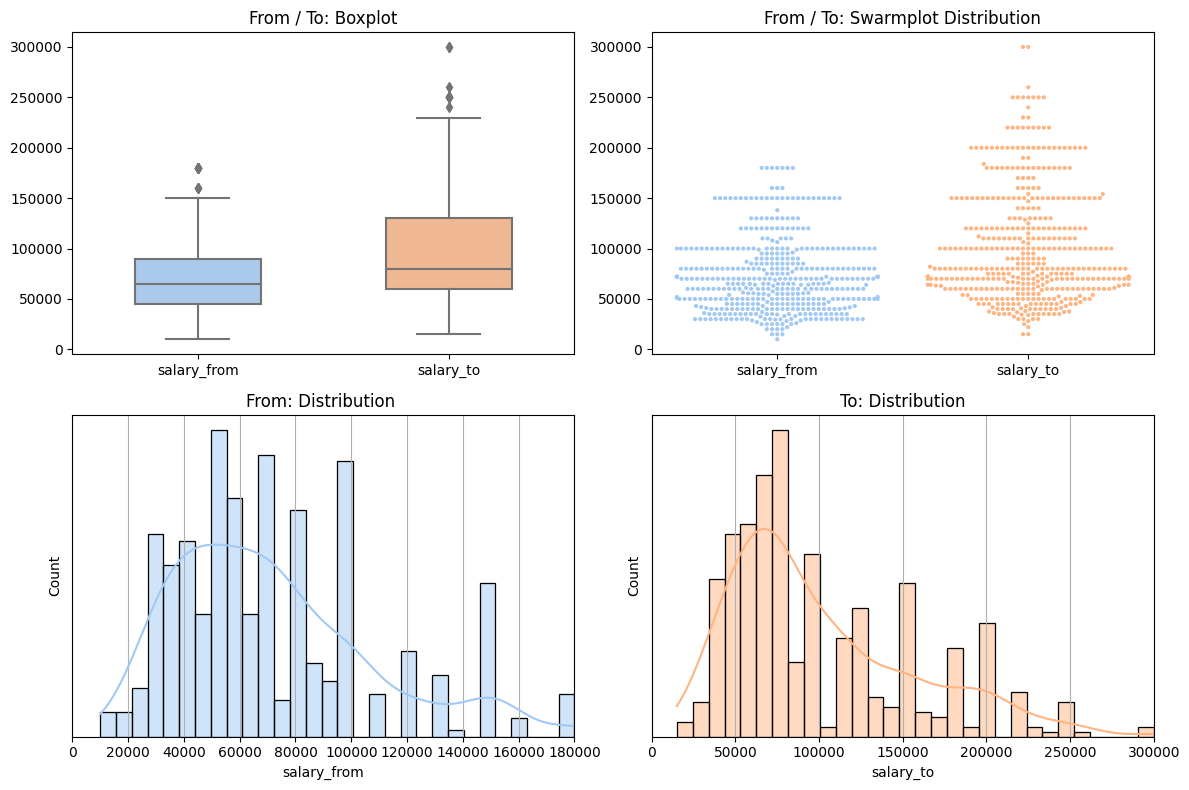

In [17]:
display_side_by_side([pd.DataFrame(dg['salary_from'].describe()),
                      pd.DataFrame(dg['salary_to'].describe())],
                     ['Describe Salary From', 'Describe Salary To'], 10)


se.set_palette("pastel")
fz = plt.figure('Salary plots', figsize=(12, 8), dpi=100)

fz.add_subplot(2, 2, 1)
plt.title('From / To: Boxplot')
se.boxplot(data=dg[['salary_from', 'salary_to']].dropna(), width=0.5)

fz.add_subplot(2, 2, 2)
plt.title('From / To: Swarmplot Distribution')
se.swarmplot(data=dg[['salary_from', 'salary_to']].dropna(), size=3)

fz.add_subplot(2, 2, 3)
plt.title('From: Distribution ')
se.histplot(dg['salary_from'].dropna(), bins=30, color='C0', kde=True)
plt.grid(True)
plt.xlim([0, dg['salary_from'].max()])
plt.yticks([], [])

fz.add_subplot(2, 2, 4)
plt.title('To: Distribution')
se.histplot(dg['salary_to'].dropna(), bins=30, color='C1', kde=True)
plt.grid(True)
plt.xlim([0, dg['salary_to'].max()])
plt.yticks([], [])
plt.tight_layout()

По графикам видно:
- среднее значение `от/до` соответственно равно 71_000 и 101_000 рублей
- медианное значение `от/до` соответственно равно 65_000 и 80_000 рублей
- большая часть вакансий лежит в промежутке от 30_000 до 100_000 рублей
- по данным `от` минимальная зарплата 10_000 рублей, а максимальная 180_000 рублей
- по данным `до` минимальная зарплата 15_000 рублей, а максимальная 300_000 рублей

Ожидаемо видно что чем выше зарплата тем меньше вакансий.

<a id="data_salary_to_lvl"></a>
### Зависимость зарплаты "от/до" от опыта

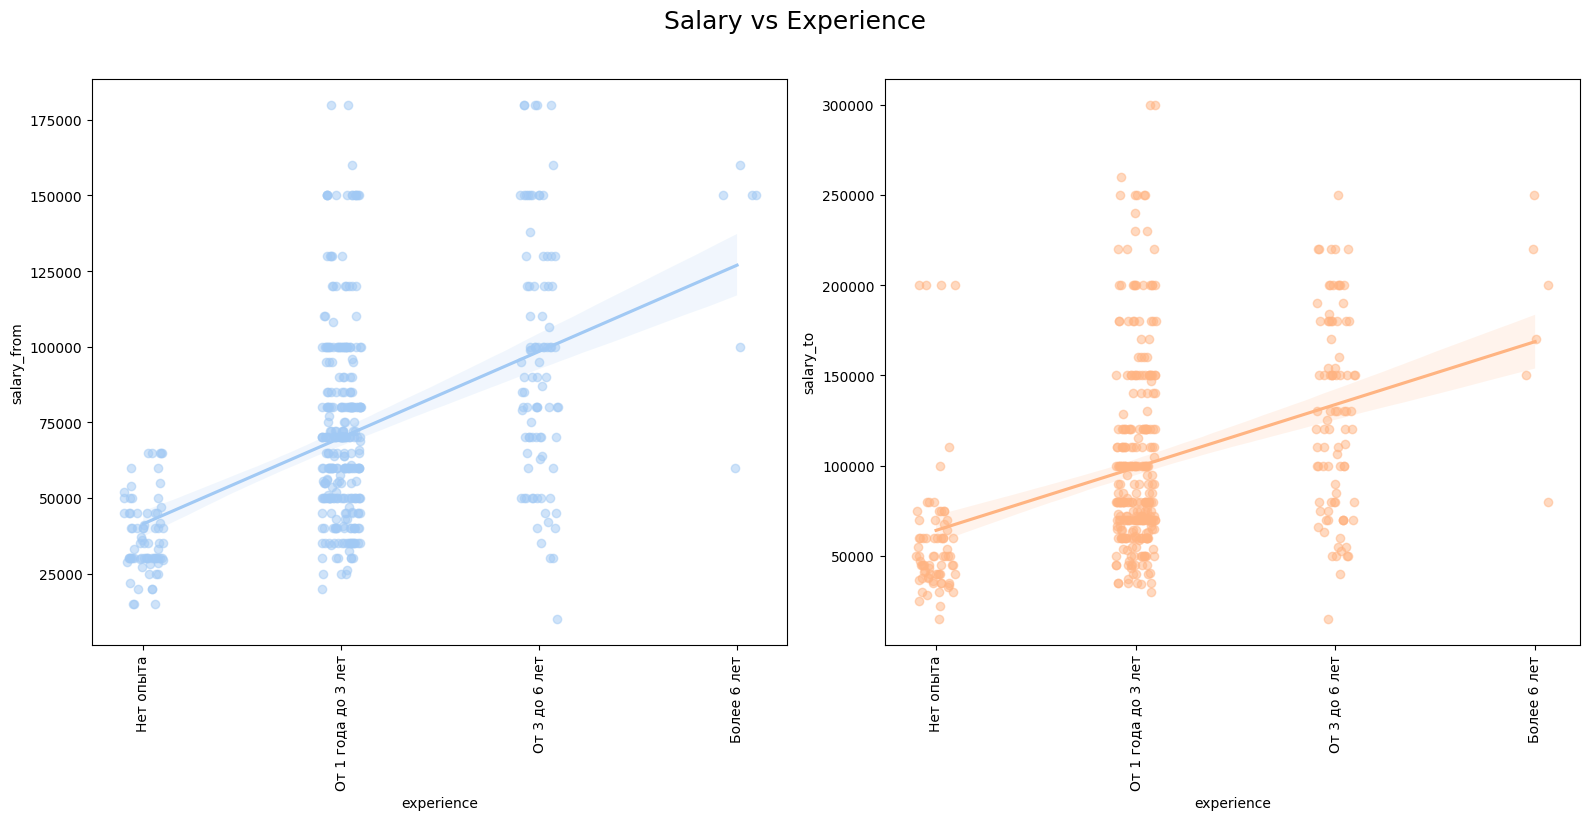

In [18]:
se.set_palette("pastel")
exp_dic = {'Нет опыта': 0, 'От 1 года до 3 лет': 1, 'От 3 до 6 лет': 2, 'Более 6 лет': 3}
experience = dg['experience'].map(exp_dic)


fig = plt.figure(figsize=(16, 8), dpi=100)
plt.suptitle('Salary vs Experience', y=1.02, fontsize=18)

fig.add_subplot(1, 2, 1);
se.regplot(x=experience, y=dg['salary_from'], color="C0", x_jitter=.1, scatter_kws={'alpha':0.5});
plt.xticks(list(range(4)), labels=exp_dic.keys(), rotation='vertical');

fig.add_subplot(1, 2, 2);
se.regplot(x=experience, y=dg['salary_to'], color="C1", x_jitter=.1, scatter_kws={'alpha':0.5});
plt.xticks(list(range(4)), labels=exp_dic.keys(), rotation='vertical');

plt.tight_layout()

По графикам можно определить:
- больше всего вакансий с требованием опыта `от 1 до 3` и `от 3 до 6`
- хорошо видна корреляция `чем больше опыта, тем выше зарплата`
- достаточно много вакансий не требующих опыта
- различия в оплате между `от 1 до 3` и `от 3 до 6` практически нет
- диапазон зарплат больше у категорий `нет опыта` и `от 3 до 6`

<a id="data_salary_mean"></a>
### Анализ сренего зраплаты

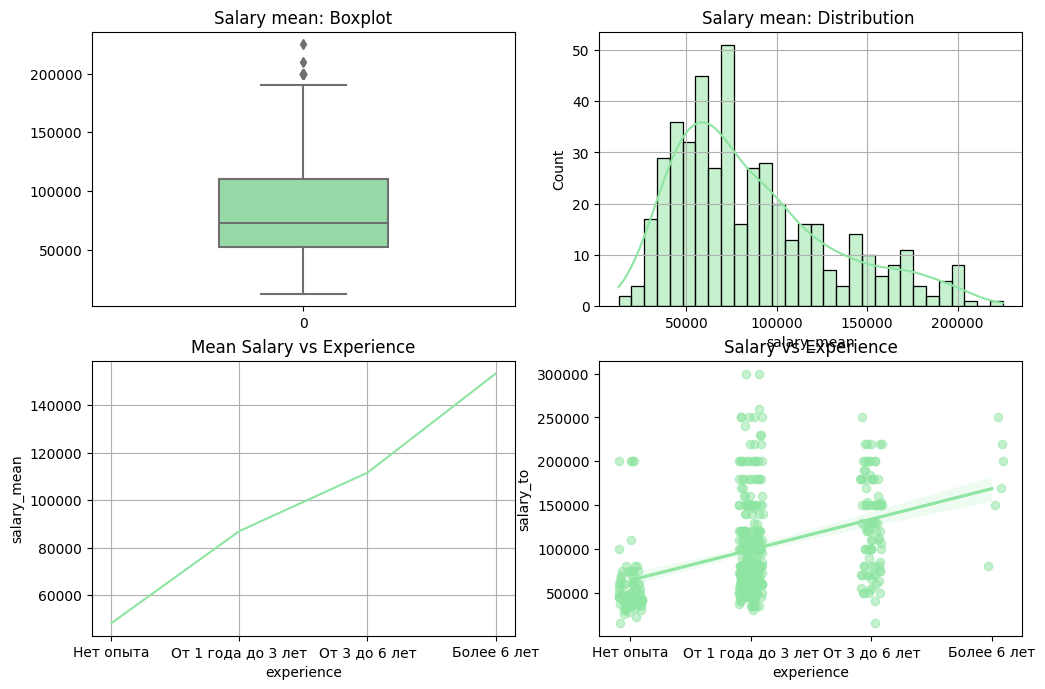

In [19]:
se.set_palette("pastel")
fz = plt.figure('Salary mean plots', figsize=(12, 8), dpi=100)

exp_dic = {'Нет опыта': 0, 'От 1 года до 3 лет': 1, 'От 3 до 6 лет': 2, 'Более 6 лет': 3}
experience = dg['experience'].map(exp_dic)

fz.add_subplot(2, 2, 1);
plt.title('Salary mean: Boxplot');
se.boxplot(data=dg['salary_mean'].dropna(), width=0.4,  color='C2');

fz.add_subplot(2, 2, 2);
plt.title('Salary mean: Distribution ');
se.histplot(dg['salary_mean'].dropna(), bins=30, color='C2', kde=True);
plt.grid(True);

fz.add_subplot(2, 2, 3);
plt.title('Mean Salary vs Experience');
se.lineplot(data=dg.pivot_table(index= 'experience', values='salary_mean').sort_values(by='salary_mean'),
            x="experience", y="salary_mean",color="C2");
plt.grid(True);

fz.add_subplot(2, 2, 4)
plt.title('Salary vs Experience');
se.regplot(x=experience, y=dg['salary_to'], color="C2", x_jitter=.1, scatter_kws={'alpha':0.5});
plt.xticks(list(range(4)), labels=exp_dic.keys());


<a id="data_salary_conclusion"></a>
### Вывод
Проанализировав данные по `от/до` и `среднего по ним` зарплат. Хорошо видно, что больше всего вакансий с зарплатой от 40_000 до 110_000 рублей. Так же на рынке труда нужны молодые специалисты, но ожидаемая зарплата для них 30_000 - 80_000 рублей. А так же правило `чем больше опыта, тем выше зарплата` так же работает.

<a id="data_salary_city"></a>
### Зависимость зарплаты от города

Для анализа зависимости зарплаты от города, для начала найдем топ 10 самых частых городов в датафрейме.

In [20]:
top_10 = df[df.city.isin(df['city'].value_counts()[0:10].index)]
top_10.pivot_table(index='city',values='vacancy_name',aggfunc='count').sort_values(by='vacancy_name',ascending=False)

,vacancy_name
city,
Москва,890
Санкт-Петербург,261
Екатеринбург,81
Новосибирск,56
Казань,52
Нижний Новгород,49
Краснодар,41
Ростов-на-Дону,32
Воронеж,29


В топ 10 ожидаемо и с огромным перевесом, попала Москва и Петербург. А так же другие города миллионники. Для анализа возьмем следующие срезы:
- Москва
- Петербург
- Воронеж
- все остальные города

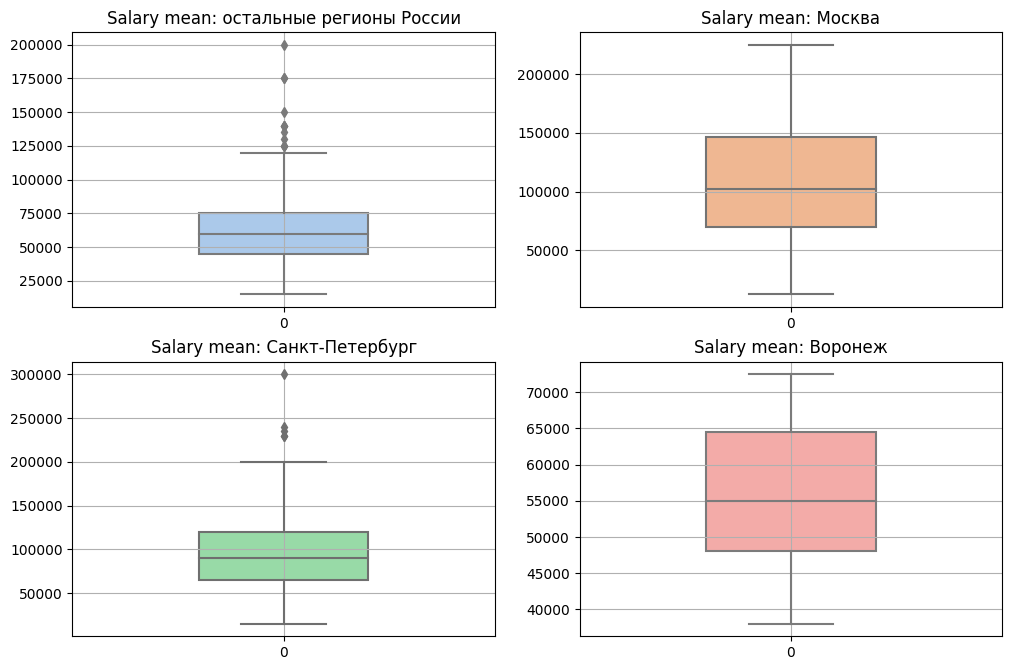

In [21]:
se.set_palette("pastel")
fz = plt.figure('Salary plots', figsize=(12, 8), dpi=100)

fz.add_subplot(2, 2, 1)
plt.title('Salary mean: остальные регионы России')
se.boxplot(data=dg.query('city not in ["Москва", "Воронеж", "Санкт-Петербург"]')
                        ['salary_mean'].dropna().reset_index(drop=True), width=0.4,  color='C0');
plt.grid(True)

fz.add_subplot(2, 2, 2)
plt.title('Salary mean: Москва')
se.boxplot(data=dg.query('city == "Москва"')
                        ['salary_mean'].dropna().reset_index(drop=True), width=0.4,  color='C1');
plt.grid(True)

fz.add_subplot(2, 2, 3)
plt.title('Salary mean: Санкт-Петербург')
se.boxplot(data=df.query('city == "Санкт-Петербург"')
                        ['salary_mean'].dropna().reset_index(drop=True), width=0.4,  color='C2');
plt.grid(True)

fz.add_subplot(2, 2, 4)
plt.title('Salary mean: Воронеж')
se.boxplot(data=df.query('city == "Воронеж"')
                        ['salary_mean'].dropna().reset_index(drop=True), width=0.4,  color='C3');
plt.grid(True)

<a id="data_salary_city_conclusion"></a>
### Вывод
По графикам видна разница зарплат в Москве и Петербурге и остальных регионах России. Без двух столиц медиана средней зарплаты, находиться на `60_000` рублей, в то время как в Москве и Петербурге она составляет `105_000` и `90_000` соответственно. Получается что средняя зарплата в столицах и регионах, отличается почти в 2 раза. Так же размах зарплат в столицах на много больше чем в регионах.

<a id="data_skills_description"></a>
## Анализ навыков и описания вакансий

#### Анализ ключевых навыков
Функция для анализа ключевых навыков и составления списка (ключевой навык - количество повторений)

In [22]:
# принимает:
# 'df' - таблица с данными

# возвращает:
# Series с отсортированными значениями (ключевой навых - количество повторений)


def top_skills(df):
    # преводим ключевые навыки из Series в List
    skills_df = df['skills'].to_list()
    # список для всех ключевых навыков со всех вакансий
    skills = []
    # заполняем список всех ключевых навыков
    for skill in skills_df:
        if skill == skill:
            for el in skill[1:-1].split(', '):
                if el != '':
                    skills.append(re.sub('\'', '', el.lower()))

    # выбираем все уникальные значения ключевых навыков
    set_skills = set(skills)
    # создаем словарь с уникальными словами и их количеством повторений
    dct_skills = {el:skills.count(el) for el in set_skills}
    # сортируем данные
    srt_skills = dict(sorted(dct_skills.items(), key=lambda x: x[1], reverse=True))
    # взращаем осортированные данные (ключевой навых - количество повторений)
    return pd.Series(srt_skills, name='skills')

<a id="data_description"></a>
### Анализ описания вакансий
Функция для анализа всех слов в описании вакансий, на выбор англ или рус языка. И составления списка (слово - количество повторений)

In [23]:
# принимает:
# 'df' - таблица с данными
# 'lang' - на каком языке ищем повторы слов
# 'word_length' - пороговое кол-во символов в слове

# возвращает:
# Series с отсортированными значениями (слово - количество повоторений) 

def top_description_words(df, lang='en', word_length=2):
    # на каком языке искать слова
    if lang == 'ru':
        lang = '[а-яА-Я]+'
    else:
        lang = '[a-zA-Z]+'
    
    # преобразуем series в list
    words_df = df['description'].to_list()
    # убираем лишнее из строки и переводим все символы в нижний регистр
    words_ls = ' '.join([re.sub('quot', ' ', 
                         re.sub(' +', ' ', 
                         re.sub('\d+', '', 
                         el.strip().lower()))) 
                         for el in words_df])
    # поиск все отдельных слов в зависимости от выбранного языка
    words_re = re.findall(lang, words_ls)
    # отбрасываем все слова короче word_length символов
    words_l2 = [el for el in words_re if len(el) > word_length]
    # отделяем все уникальные слова
    words_st = set(words_l2)
    # создаем словарь с уникальными словами и их количеством повторений
    words_cnt = {el : words_l2.count(el) for el in words_st}
    # возращаем Series с отсортированными значениями (слово - количество повоторений)
    return pd.Series(dict(sorted(words_cnt.items(), key=lambda x: x[1], reverse=True)))

Ищем самые часто повторяющиеся слова:
- на русском
- на английском

**Очень долго обрабатывает, лучше запустить 1 раз**

In [24]:
# поиск самых часто повторяющихся ключевых навыков
top_ds_skills = top_skills(df)
# поиск самых часто повторяющихся слов в описании вакансии на английском
top_ds_en_words = top_description_words(df, 'en')
# поиск самых часто повторяющихся слов в описании вакансии на русском
top_ds_ru_words = top_description_words(df, 'ru', 3)

Выводим на экран самые часто встречающиеся:
- ключевые навыки
- повторяющиеся англ слова в описании вакансий
- повторяющиеся рус слова в описании вакансий

In [25]:
count = 20

sk = top_ds_skills.head(count)
en = top_ds_en_words.head(count)
ru = top_ds_ru_words.head(count)

display_side_by_side([pd.DataFrame({'skills':sk.index, 'count':sk.values}),
                      pd.DataFrame({'words':en.index, 'count':en.values}),
                      pd.DataFrame({'words':ru.index,'count':ru.values})],
                     ['Top skills:', 'Top EN description words:', 'Top RU description words:'], 10) 

,skills,count
0,аналитическое мышление,505
1,sql,500
2,ms powerpoint,374
3,анализ данных,362
4,работа с большим объемом информации,350
5,бизнес-анализ,230
6,ms excel,215
7,bpmn,213
8,python,163
9,работа в команде,161


По таблицам можно увидеть, самые востребованные навыки по всем объявлениям. Так же по повторяющимся английским словам можно убедиться, что такие навыки как `sql`, `excel`, `powerpoint`, `python`, `uml` и другие дублируют самые часто встречающиеся ключевые умения. Таблица повторяющихся русских слов дает только общее понимание, и служит скорее для иллюстрации какой опыт и soft skills востребованы на рынке труда.

<a id="data_skills_to_lvl"></a>
### Сравнение ключевых навыков между уровнями вакансий
Сравниваем ключевые навыки и самые часто повторяющиеся англ слова в вакансиях в зависимости от уровня работника
- junior - "Нет опыта"
- middle - "От 1 года до 3 лет"
- senior - "От 3 до 6 лет"
- lead - "Более 6 лет"

**Очень долго обрабатывает, лучше запустить 1 раз**

In [26]:
df_jun = df.query('experience == "Нет опыта"')
df_mid = df.query('experience == "От 1 года до 3 лет"')
df_sen = df.query('experience == "От 3 до 6 лет"')
df_lead = df.query('experience == "Более 6 лет"')

count = 10

jun_skills = top_skills(df_jun).head(count)
mid_skills = top_skills(df_mid).head(count)
sen_skills = top_skills(df_sen).head(count)
lead_skills = top_skills(df_lead).head(count)

jun_en_words = top_description_words(df_jun).head(count)
mid_en_words = top_description_words(df_mid).head(count)
sen_en_words = top_description_words(df_sen).head(count)
lead_en_words = top_description_words(df_lead).head(count)

jun_ru_words = top_description_words(df_jun,'ru',3).head(count)
mid_ru_words = top_description_words(df_mid,'ru',3).head(count)
sen_ru_words = top_description_words(df_sen,'ru',3).head(count)
lead_ru_words = top_description_words(df_lead,'ru',3).head(count)

In [27]:
display_side_by_side([pd.DataFrame({'skills':jun_skills.index, 'count':jun_skills.values}),
                      pd.DataFrame({'words':jun_en_words.index, 'count':jun_en_words.values}),
                      pd.DataFrame({'words':jun_ru_words.index, 'count':jun_ru_words.values})],
                     ['Top skills for junior', 'Top en words for junior', 'Top ru words for junior'], 10) 
display_side_by_side([pd.DataFrame({'skills':mid_skills.index, 'count':mid_skills.values}),
                      pd.DataFrame({'words':mid_en_words.index, 'count':mid_en_words.values}),
                      pd.DataFrame({'words':mid_ru_words.index, 'count':mid_ru_words.values})],
                     ['Top skills for middle', 'Top en words for middle', 'Top ru words for middle'], 10) 
display_side_by_side([pd.DataFrame({'skills':sen_skills.index, 'count':sen_skills.values}),
                      pd.DataFrame({'words':sen_en_words.index, 'count':sen_en_words.values}),
                      pd.DataFrame({'words':sen_ru_words.index, 'count':sen_ru_words.values})],
                     ['Top skills for senior', 'Top en words for senior', 'Top ru words for senior'], 10) 
display_side_by_side([pd.DataFrame({'skills':lead_skills.index, 'count':lead_skills.values}),
                      pd.DataFrame({'words':lead_en_words.index, 'count':lead_en_words.values}),
                      pd.DataFrame({'words':lead_ru_words.index, 'count':lead_ru_words.values})],
                     ['Top skills for lead', 'Top en words for lead', 'Top ru words for lead'], 10) 

,skills,count
0,аналитическое мышление,69
1,работа с большим объемом информации,61
2,ms powerpoint,58
3,работа в команде,44
4,анализ данных,37
5,sql,32
6,ms excel,30
7,поиск информации в интернет,19
8,пользователь пк,19
9,грамотная речь,18


,skills,count
0,sql,341
1,аналитическое мышление,330
2,анализ данных,244
3,ms powerpoint,243
4,работа с большим объемом информации,236
5,бизнес-анализ,151
6,ms excel,145
7,bpmn,124
8,python,111
9,разработка технических заданий,99


,skills,count
0,sql,125
1,аналитическое мышление,102
2,анализ данных,80
3,bpmn,77
4,ms powerpoint,73
5,бизнес-анализ,66
6,uml,63
7,работа с большим объемом информации,53
8,аналитика,47
9,системный анализ,45


,skills,count
0,аналитическое мышление,4
1,бизнес-анализ,4
2,ms visio,3
3,bpmn,3
4,системный анализ,3
5,моделирование бизнес процессов,3
6,оптимизация бизнес-процессов,3
7,sql,2
8,1с-битрикс,2
9,power bi,2


<a id="data_skills_conclusion"></a>
### Вывод
Сначала были найдены самые нужные ключевые умения и повторяющиеся слова из описания для всех вакансий, а потом они были разложены по уровню вакансии. По таблицам можно отследить, что для JUNIOR позиций ключевые навыки более общие и скорее направлены на понимание и обучаемость кандидата. А начиная с MIDDLE требования приобретают конкретику. Такие требования как: `пользователь пк`, `поиск информации в интернет`, `грамотная речь` вообще не попадают в топ 10 самых частых в вакансиях выше начального уровня. 

Так же из интересного можно заметить как слово `опыт` поднимается снизу у JUNIOR в верх у более опытных уровней.

<a id="final_conclusion"></a>
## Общие выводы
Используя `api`, был написан парсер для ресурса по поиску работы `hh.ru`, в который можно подавать `кастомизированные запросы`. Название вакансии(в.ч. и сложные/составные запросы `Manager AND Doctor`), регион (с той точностью что позволяет сервис).

После этого запустили парсинг вакансий по запросу `Аналитик`, `по всей России`. Собранные данные были обработаны(напр. раставлены типы данных) и записаны в файл `CSV`.

Далее эти данные были предобработаны: удалены явные дубликаты, обработаны валютные вакансии. Потом был добавлен новый столбец со средней ценой в зависимости от значения зарплаты `от/до` по формуле `(salary_from + salary_to) / 2`. 

Затем была проанализирована зарплата по вакансиям:
- среднее значение `от/до` соответственно равно `71_000 и 101_000 рублей`
- медианное значение `от/до` соответственно равно `65_000 и 80_000 рублей`
- большая часть вакансий лежит в промежутке от `30_000 до 100_000 рублей`
- по данным `от` минимальная зарплата `10_000 рублей`, а максимальная `180_000 рублей`
- по данным `до` минимальная зарплата `15_000 рублей`, а максимальная `300_000 рублей`

- больше всего вакансий с требованием опыта `от 1 до 3` и `от 3 до 6`
- хорошо видна корреляция `чем больше опыта, тем выше зарплата`
- достаточно много вакансий не требующих опыта
- различия в оплате между `от 1 до 3` и `от 3 до 6` практически нет
- диапазон зарплат больше у категорий `нет опыта` и `от 3 до 6`

Так же на рынке труда нужны молодые специалисты, но ожидаемая зарплата для них `30_000 - 80_000` рублей. А так же правило `чем больше опыта, тем выше зарплата` так же работает.

Посмотрев на зависимость городов и зарплата, получили, что без двух столиц медиана средней зарплаты, находиться на `60_000` рублей, в то время как в `Москве` и `Петербурге` она составляет `105_000` и `90_000` соответственно. Получается что средня зарплата в столицах и регионах, отличается почти в `2 раза`. Так же размах зарплат в столицах на много больше чем в регионах.

И в конце были найдены самые главные и часто повторяющиеся ключевые навыки и ключевые слова из описания вакансий. 

Сначала самые востребованные навыки по всем объявлениям. Так же по повторяющимся английским словам можно убедиться, что такие навыки как `sql`, `excel`, `powerpoint`, `python`, `uml` и другие дублируют самые часто встречающиеся ключевые умения. Таблица повторяющихся русских слов дает только общее понимание, и служит скорее для иллюстрации какой опыт и `soft skills` востребованы на рынке труда.

Затем ключевые требования для каждой из 4 уровней специалистов:
- junior - "Нет опыта"
- middle - "От 1 года до 3 лет"
- senior - "От 3 до 6 лет"
- lead - "Более 6 лет"

Так например, для `JUNIOR` позиций ключевые навыки более общие и скорее направлены на понимание и обучаемость кандидата. А начиная с `MIDDLE` требования приобретают конкретику. Такие требования как: `пользователь пк`, `поиск информации в интернет`, `грамотная речь` вообще не попадают в топ 10 самых частых в вакансиях выше начального уровня. 

Так же из интересного можно заметить как слово `опыт` поднимается снизу у JUNIOR в верх у более опытных уровней.

Из всего это можно сделать выводы, что куда расти `есть`, а главное, теперь можно с помощью анализа понять `куда расти`.